<a href="https://colab.research.google.com/github/Alamsyah-WM/Classification-DBP-Binding-vs-Non-Binding/blob/Minggu4/Minggu4_SubCon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup


---


Installing packages pandas, numpy, tqdm, sckit-learn, and pretrain model

In [ ]:
!pip install fair-esm -q
!pip install torch torchvision torchaudio
!pip install fair-esm scikit-learn pandas numpy tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.3 MB/s eta 0:00:00


#Import Library


---


Importing Library from installed setup

In [ ]:
import torch
import pandas as pd
import numpy as np
import esm
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from IPython.display import display, Markdown
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import copy
from transformers import EsmModel, EsmConfig
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
def set_seed(seed=42):
    """Sets the random seed for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # For all GPUs
    torch.cuda.manual_seed_all(seed) # For all GPUs

    # Ensures that CUDA operations are deterministic even if they might be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed} for reproducibility.")

# Call the function to set the seed
set_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Random seed set to 42 for reproducibility.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df_pdb = pd.read_csv('/content/drive/MyDrive/Bioinformatika/PDB1063-186.csv')
df_uni = pd.read_csv('/content/drive/MyDrive/Bioinformatika/UniSwiss.csv')

def show_dataset_info(df, dataset_name, stage="Before Cleaning"):
    """Menampilkan informasi dataset"""
    if df is None or df.empty:
        print(f"{stage} - Dataset {dataset_name} is empty")
        return

    total_rows = len(df)
    train_count = len(df[df['set'] == 'train'])
    test_count = len(df[df['set'] == 'test'])

    train_label_0 = len(df[(df['set'] == 'train') & (df['label'] == 0)])
    train_label_1 = len(df[(df['set'] == 'train') & (df['label'] == 1)])
    test_label_0 = len(df[(df['set'] == 'test') & (df['label'] == 0)])
    test_label_1 = len(df[(df['set'] == 'test') & (df['label'] == 1)])

    print(f"\n{stage} - {dataset_name} Dataset:")
    print(f"Total rows: {total_rows}")
    print(f"Train set: {train_count} rows")
    print(f"  - Label 0: {train_label_0} rows")
    print(f"  - Label 1: {train_label_1} rows")
    print(f"Test set: {test_count} rows")
    print(f"  - Label 0: {test_label_0} rows")
    print(f"  - Label 1: {test_label_1} rows")

def cleaning_crossset_duplicates(df, dataset_name=None):
    """
    Membersihkan duplikat cross-set: jika sequence muncul di test dan train,
    hapus hanya dari TRAIN, test tetap dipertahankan.
    """

    print(f"\n=== Checking Cross-Set Duplicates ({dataset_name}) ===")

    # Info awal
    show_dataset_info(df, dataset_name, "Before Cleaning")

    # Pisahkan train/test
    train_df = df[df["set"] == "train"].copy()
    test_df = df[df["set"] == "test"].copy()

    # Ambil sequence
    train_seq = set(train_df["sequence"].tolist())
    test_seq = set(test_df["sequence"].tolist())

    # Cari duplikat antar set
    overlap = train_seq.intersection(test_seq)
    print(f"Cross-set duplicates (train ∩ test): {len(overlap)}")

    # Hapus dari TRAIN
    train_clean = train_df[~train_df["sequence"].isin(overlap)]

    rows_removed = len(train_df) - len(train_clean)
    print(f"Rows removed from TRAIN: {rows_removed}")

    # Gabungkan kembali
    df_clean = pd.concat([train_clean, test_df], ignore_index=True)

    # Info final
    show_dataset_info(df_clean, dataset_name, "After Cleaning")

    return df_clean


# Proses cleaning dengan menampilkan info
print("=" * 50)
print("DATASET CLEANING PROCESS")
print("=" * 50)

df_pdb_clean = cleaning_crossset_duplicates(df_pdb, "PDB")
print("\n" + "=" * 50)
df_uni_clean = cleaning_crossset_duplicates(df_uni, "UniSwiss")
print("\n" + "=" * 50)

# Summary akhir
print("\nFINAL SUMMARY:")
print(f"PDB dataset - Final count: {len(df_pdb_clean)}")
print(f"UniSwiss dataset - Final count: {len(df_uni_clean)}")
print(f"Combined total: {len(df_pdb_clean) + len(df_uni_clean)}")

DATASET CLEANING PROCESS

=== Checking Cross-Set Duplicates (PDB) ===

Before Cleaning - PDB Dataset:
Total rows: 1249
Train set: 1063 rows
  - Label 0: 545 rows
  - Label 1: 518 rows
Test set: 186 rows
  - Label 0: 93 rows
  - Label 1: 93 rows
Cross-set duplicates (train ∩ test): 75
Rows removed from TRAIN: 75

After Cleaning - PDB Dataset:
Total rows: 1174
Train set: 988 rows
  - Label 0: 545 rows
  - Label 1: 443 rows
Test set: 186 rows
  - Label 0: 93 rows
  - Label 1: 93 rows


=== Checking Cross-Set Duplicates (UniSwiss) ===

Before Cleaning - UniSwiss Dataset:
Total rows: 9762
Train set: 9000 rows
  - Label 0: 4500 rows
  - Label 1: 4500 rows
Test set: 762 rows
  - Label 0: 381 rows
  - Label 1: 381 rows
Cross-set duplicates (train ∩ test): 3
Rows removed from TRAIN: 35

After Cleaning - UniSwiss Dataset:
Total rows: 9727
Train set: 8965 rows
  - Label 0: 4500 rows
  - Label 1: 4465 rows
Test set: 762 rows
  - Label 0: 381 rows
  - Label 1: 381 rows


FINAL SUMMARY:
PDB dataset 

# Supcon

In [ ]:
# Load ESM2 tokenizer + model (HuggingFace)
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D").to(device)
esm_model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
          (dense): Linear(in_features=320, out_features=1280, bias=True)
        )
        (output): EsmOutput(
        

##Define Function and class


In [ ]:
class ESMBackbone(nn.Module):
    def __init__(self, proj_dim=128, in_dim=320, model_name="facebook/esm2_t6_8M_UR50D"):
        super().__init__()
        self.hidden_dim = in_dim  # <— tambahkan ini!

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.esm = EsmModel.from_pretrained(model_name)

        self.proj = nn.Linear(in_dim, proj_dim)

    def forward(self, x, return_proj=False):
        # CASE 1 → RAW SEQUENCE (list of strings)
        if isinstance(x[0], str):
            tokens = self.tokenizer(
                x, padding=True, truncation=True, return_tensors='pt'
            ).to(self.proj.weight.device)

            out = self.esm(**tokens)
            h = out.last_hidden_state[:, 0]   # CLS embedding

        # CASE 2 → EMBEDDING (tensor)
        else:
            h = x.to(self.proj.weight.device)

        z = self.proj(h)
        return z if return_proj else h



class SupConLoss(nn.Module):
    def __init__(self, temperature=0.05):
        super().__init__()
        self.temperature = temperature
        self.eps = 1e-8

    def forward(self, features, labels):
        device = features.device
        batch_size = features.size(0)

        features = nn.functional.normalize(features, dim=1)

        # cosine similarity matrix
        sim_matrix = torch.matmul(features, features.T) / self.temperature

        labels = labels.unsqueeze(0) == labels.unsqueeze(1)
        mask = labels.float().to(device)

        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        logits = sim_matrix - logits_max.detach()

        exp_logits = torch.exp(logits) * (1 - torch.eye(batch_size).to(device))

        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + self.eps)

        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + self.eps)

        loss = -mean_log_prob_pos.mean()
        return loss

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3, n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, n_classes)
        )

    def forward(self, x):
        return self.net(x)

class FullModel(nn.Module):
    def __init__(self, backbone, classifier):
        super().__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, seqs):
        # seqs: list of strings OR tensor embeddings
        with torch.no_grad():
            emb = self.backbone(seqs)
        logits = self.classifier(emb)
        return logits



class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = torch.tensor(y).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ProteinSupConDataset(Dataset):
    """
    Dataset untuk Supervised Contrastive Learning di protein.
    Positive pair:
      1. Dari augmentasi sequence (selalu)
      2. Dari sequence lain dengan label sama (opsional)
    """
    def __init__(self, sequences, labels, augment=True, use_label_pos=False):
        """
        sequences : list of str
        labels : list of int
        augment : bool, gunakan protein-aware augmentation
        use_label_pos : bool, jadikan sequence lain dengan label sama sebagai positive pair tambahan
        """
        self.sequences = sequences
        self.labels = labels
        self.augment = augment
        self.use_label_pos = use_label_pos

        # Mapping label -> index list
        self.label_to_indices = {}
        for idx, label in enumerate(labels):
            self.label_to_indices.setdefault(label, []).append(idx)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]

        # 1. Augmentasi sequence → selalu ada 2 versi
        if self.augment:
            seq1 = augment_protein_sequence(seq)
            seq2 = augment_protein_sequence(seq)
        else:
            seq1 = seq2 = seq

        positive_pairs = [[seq1, seq2]]

        # 2. Tambahkan positive dari label sama (opsional)
        if self.use_label_pos:
            same_label_indices = self.label_to_indices[label].copy()
            same_label_indices.remove(idx)  # hapus diri sendiri
            if same_label_indices:
                # ambil 1 random sequence lain dengan label sama
                idx2 = random.choice(same_label_indices)
                seq_pos = self.sequences[idx2]
                if self.augment:
                    seq_pos = augment_protein_sequence(seq_pos)
                positive_pairs.append([seq1, seq_pos])

        return positive_pairs, label



In [ ]:
def train_supcon(backbone, train_loader, val_loader, epochs=10, lr=1e-4, device=device):
    backbone = backbone.to(device)
    criterion = SupConLoss()
    optimizer = torch.optim.AdamW(backbone.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    train_losses, val_losses = [], []
    print("\n🚀 Starting SupCon Pretraining (Safe)...\n")

    for epoch in range(1, epochs+1):
        backbone.train()
        total_train_loss = 0

        for X, y in train_loader:
            y = y.to(device)

            # Raw sequence → list of strings
            if isinstance(X[0], str):
                inp = list(X)
            else:
                inp = X.to(device)

            # Forward backbone → embedding
            proj = backbone(inp, return_proj=True)

            # Jika batch terlalu kecil, SupConLoss masih jalan
            if proj.size(0) != y.size(0):
                raise ValueError(f"Batch size mismatch: proj {proj.size(0)} vs labels {y.size(0)}")

            loss = criterion(proj, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        train_losses.append(train_loss)

        # ===== Validation =====
        backbone.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                y = y.to(device)

                if isinstance(X[0], str):
                    inp = list(X)
                else:
                    inp = X.to(device)

                proj = backbone(inp, return_proj=True)
                total_val_loss += criterion(proj, y).item()

        val_loss = total_val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")

    return backbone, train_losses, val_losses



def train_classifier(
    backbone, classifier, train_loader, val_loader,
    epochs=20, lr=1e-3, device=device
):
    # ============================
    #  Setup BackBone (Freeze)
    # ============================
    backbone = backbone.to(device)
    backbone.eval()
    for p in backbone.parameters():
        p.requires_grad = False

    classifier = classifier.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)

    # history
    train_losses = []
    val_losses = []
    val_accs   = []

    # ============================
    #  TRAINING LOOP
    # ============================
    for epoch in range(1, epochs + 1):
        classifier.train()
        total_train_loss = 0.0

        for X, y in train_loader:
            y = y.to(device)

            # input is string or tensor?
            if isinstance(X[0], str):
                inp = list(X)
            else:
                inp = X.to(device)

            # get embeddings from frozen backbone
            with torch.no_grad():
                emb = backbone(inp)

            # forward classifier
            logits = classifier(emb)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ============================
        # VALIDATION
        # ============================
        classifier.eval()
        total_val_loss = 0.0
        preds_all, labels_all = [], []

        with torch.no_grad():
            for X, y in val_loader:
                y = y.to(device)

                if isinstance(X[0], str):
                    inp = list(X)
                else:
                    inp = X.to(device)

                emb = backbone(inp)
                logits = classifier(emb)

                total_val_loss += criterion(logits, y).item()

                preds_all.extend(torch.argmax(logits, 1).cpu().numpy())
                labels_all.extend(y.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_acc = accuracy_score(labels_all, preds_all)
        val_accs.append(val_acc)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Acc: {val_acc:.3f}")

    # return 4 value
    return classifier, train_losses, val_losses, val_accs


@torch.no_grad()
def esm_embed_sequences(seqs):
    embeddings = []

    for seq in seqs:
        tokens = tokenizer(
            seq,
            return_tensors="pt",
            truncation=True,
            max_length=1024
        )

        tokens = {k: v.to(device) for k, v in tokens.items()}
        out = esm_model(**tokens)
        cls = out.last_hidden_state[:, 0].squeeze().cpu()
        embeddings.append(cls)

    return torch.stack(embeddings)  # tensor (N, 320)

import random

# ================================
# Protein-Aware Augmentation
# ================================
aa_groups = {
    "A": ["G", "S", "T"],  # small polar
    "R": ["K", "H"],       # positive charge
    "N": ["Q", "D"],       # polar
    "D": ["E", "N"],       # negative
    "C": ["S"],            # special
    "E": ["D", "Q"],
    "Q": ["N", "E"],
    "G": ["A", "S"],
    "H": ["R", "K"],
    "I": ["L", "V"],
    "L": ["I", "V"],
    "K": ["R", "H"],
    "M": ["L"],
    "F": ["Y", "W"],
    "P": ["A"],
    "S": ["T", "A"],
    "T": ["S", "A"],
    "W": ["F", "Y"],
    "Y": ["F", "W"],
    "V": ["I", "L"],
}

def random_substitution(seq, prob=0.1):
    """Ganti beberapa AA dengan AA sejenis (conservative)."""
    seq_aug = ""
    for aa in seq:
        if aa in aa_groups and random.random() < prob:
            seq_aug += random.choice(aa_groups[aa])
        else:
            seq_aug += aa
    return seq_aug

def random_mask(seq, prob=0.05):
    """Ganti beberapa AA dengan X (masking)."""
    return "".join([aa if random.random() > prob else "X" for aa in seq])

def random_crop(seq, crop_len=100):
    """Ambil subsekuens panjang crop_len."""
    if len(seq) <= crop_len:
        return seq
    start = random.randint(0, len(seq) - crop_len)
    return seq[start:start+crop_len]

# ================================
# Augmentation pipeline
# ================================
def augment_protein_sequence(seq):
    seq = random_substitution(seq, prob=0.1)
    seq = random_mask(seq, prob=0.05)
    seq = random_crop(seq, crop_len=256)  # atau sesuai max length ESM
    return seq




In [ ]:
#versi perplexity
# bedanya dg yg sebelumnya itu ini ga pke augmentasi
class ProteinSupConDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# pke mean pooling
class ESMBackbone(nn.Module):
    def __init__(self, proj_dim=128, in_dim=320, model_name="facebook/esm2_t6_8M_UR50D"):
        super().__init__()
        self.hidden_dim = in_dim  # <— tambahkan ini!

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.esm = EsmModel.from_pretrained(model_name)

        self.proj = nn.Linear(in_dim, proj_dim)

    def forward(self, x, return_proj=False):
        # CASE 1 → RAW SEQUENCE (list of strings)
        if isinstance(x[0], str):
            tokens = self.tokenizer(
                x, padding=True, truncation=True, return_tensors='pt'
            ).to(self.proj.weight.device)

            out = self.esm(**tokens)
            h = out.last_hidden_state.mean(dim=1)  # Mean pooling seluruh token

        # CASE 2 → EMBEDDING (tensor)
        else:
            h = x.to(self.proj.weight.device)

        z = self.proj(h)
        return z if return_proj else h



##Evaluate and Visualize


In [ ]:
@torch.no_grad()
def evaluate_model(model, dataloader, device='cuda'):
    model.eval()

    all_preds = []
    all_labels = []
    all_prob = []

    for X, y in dataloader:
        y = y.to(device)

        # If input is raw AA sequences (list of str)
        if isinstance(X[0], str):
            inp = list(X)
        else:
            inp = X.to(device)

        logits = model(inp)
        probs = logits.softmax(dim=1)

        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_prob.extend(probs.cpu().numpy())

    # Convert to numpy
    y_true = all_labels
    y_pred = all_preds
    y_prob = all_prob

    # ============================
    #          METRICS
    # ============================
    acc = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)

    # ROC-AUC hanya untuk binary (kelas 1)
    roc_auc = roc_auc_score(y_true, [p[1] for p in y_prob])

    # Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Classification report
    class_report = classification_report(
        y_true, y_pred,
        target_names=["Non-binding (0)", "Binding (1)"],
        digits=3
    )

    # ============================
    #     PRINT HASIL
    # ============================
    print("\n=== Evaluation Result ===")
    print(f"Accuracy:      {acc:.3f}")
    print(f"Precision(M):  {precision_macro:.3f}")
    print(f"Recall(M):     {recall_macro:.3f}")
    print(f"F1 Macro:      {f1_macro:.3f}")
    print(f"F1 Weighted:   {f1_weighted:.3f}")
    print(f"MCC:           {mcc:.3f}")
    print(f"Specificity:   {specificity:.3f}")
    print(f"ROC-AUC:       {roc_auc:.3f}")

    print("\n=== Classification Report ===")
    print(class_report)

    # ============================
    #     CONFUSION MATRIX PLOT
    # ============================
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Non-binding", "Binding"],
                yticklabels=["Non-binding", "Binding"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return {
        "Accuracy": acc,
        "Precision_macro": precision_macro,
        "Recall_macro": recall_macro,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
        "MCC": mcc,
        "Specificity": specificity,
        "ROC_AUC": roc_auc,
        "Classification_Report": class_report
    }, y_pred, y_prob

In [ ]:
# Function to visualize the confusion matrix and ROC curve
def visualize_metrics(y_true_pdb, y_pred_pdb, y_prob_pdb, y_true_uni, y_pred_uni, y_prob_uni, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay.from_predictions(y_true_pdb, y_pred_pdb, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(y_true_uni, y_pred_uni, cmap="Blues", ax=plt.gca())
    plt.title(f"Confusion Matrix - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    RocCurveDisplay.from_predictions(y_true_pdb, y_prob_pdb[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (PDB)")

    plt.subplot(1, 2, 2)
    RocCurveDisplay.from_predictions(y_true_uni, y_prob_uni[:, 1], color="darkorange", ax=plt.gca())
    plt.title(f"ROC Curve - {model_name} (UniSwiss)")
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_losses(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

##Execution

### load dll

In [ ]:
df_pdb_train = df_pdb_clean[df_pdb_clean['set'] == 'train']
df_pdb_test  = df_pdb_clean[df_pdb_clean['set'] == 'test']

x_pdb_train_emb = esm_embed_sequences(df_pdb_train['sequence'])
x_pdb_test_emb  = esm_embed_sequences(df_pdb_test['sequence'])

y_pdb_train = df_pdb_train['label'].values
y_pdb_test  = df_pdb_test['label'].values

X_pdb_train, X_pdb_val, y_pdb_train, y_pdb_val = train_test_split(
    x_pdb_train_emb,
    y_pdb_train,
    test_size=0.1,
    random_state=42,
    stratify=y_pdb_train
)

# UNI
df_uni_train = df_uni_clean[df_uni_clean['set'] == 'train']
df_uni_test  = df_uni_clean[df_uni_clean['set'] == 'test']

x_uni_train_emb = esm_embed_sequences(df_uni_train['sequence'])
x_uni_test_emb  = esm_embed_sequences(df_uni_test['sequence'])

y_uni_train = df_uni_train['label'].values
y_uni_test  = df_uni_test['label'].values

X_uni_train, X_uni_val, y_uni_train, y_uni_val = train_test_split(
    x_uni_train_emb,
    y_uni_train,
    test_size=0.1,
    random_state=42,
    stratify=y_uni_train
)

In [ ]:
batch_size = 32

# PDB
train_ds_pdb = SequenceDataset(X_pdb_train, y_pdb_train)
val_ds_pdb   = SequenceDataset(X_pdb_val,   y_pdb_val)
test_ds_pdb  = SequenceDataset(x_pdb_test_emb,  y_pdb_test)


train_loader_pdb = DataLoader(train_ds_pdb, batch_size=32, shuffle=True)
val_loader_pdb   = DataLoader(val_ds_pdb,   batch_size=32)
test_loader_pdb   = DataLoader(test_ds_pdb,   batch_size=32)

# UNI
train_ds_uni = SequenceDataset(X_uni_train, y_uni_train)
val_ds_uni   = SequenceDataset(X_uni_val,   y_uni_val)
test_ds_uni  = SequenceDataset(x_uni_test_emb,  y_uni_test)


train_loader_uni = DataLoader(train_ds_uni, batch_size=32, shuffle=True)
val_loader_uni   = DataLoader(val_ds_uni,   batch_size=32)
test_loader_uni   = DataLoader(test_ds_uni,   batch_size=32)


### train (0.704)
pke augmentation


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=100, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
# backbone = ESMBackbone(proj_dim=128)
# backbone.load_state_dict(torch.load("supcon_esm_backbone.pt", map_location="cuda"))
# backbone.to("cuda")
# backbone.eval()

# print("Loaded SupCon-trained ESM backbone ✔")


In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 2 (0.692)
ga pke augmentation


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=100, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 3 (0.720)
ga pke augmentation + pke mean pooling


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=100, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



Mulai train supcon...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting SupCon Pretraining (Safe)...

Epoch 1/100 | Train: 3.4189 | Val: 2.5579
Epoch 2/100 | Train: 3.3935 | Val: 2.5629
Epoch 3/100 | Train: 3.3881 | Val: 2.5417
Epoch 4/100 | Train: 3.3759 | Val: 2.4873
Epoch 5/100 | Train: 3.3689 | Val: 2.4429
Epoch 6/100 | Train: 3.3539 | Val: 2.3662
Epoch 7/100 | Train: 3.3401 | Val: 2.3024
Epoch 8/100 | Train: 3.3304 | Val: 2.2401
Epoch 9/100 | Train: 3.3148 | Val: 2.2004
Epoch 10/100 | Train: 3.3022 | Val: 2.1584
Epoch 11/100 | Train: 3.2994 | Val: 2.1300
Epoch 12/100 | Train: 3.2884 | Val: 2.0671
Epoch 13/100 | Train: 3.2778 | Val: 2.0811
Epoch 14/100 | Train: 3.2744 | Val: 2.0418
Epoch 15/100 | Train: 3.2680 | Val: 1.9602
Epoch 16/100 | Train: 3.2528 | Val: 2.0292
Epoch 17/100 | Train: 3.2586 | Val: 1.9989
Epoch 18/100 | Train: 3.2517 | Val: 1.9136
Epoch 19/100 | Train: 3.2479 | Val: 2.0584
Epoch 20/100 | Train: 3.2356 | Val: 1.9792
Epoch 21/100 | Train: 3.2225 | Val: 1.8216
Epoch 22/100 | Train: 3.2317 | Val: 1.9113
Epoch 23/100 | Train:

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 3.2 (0.717) 200 epoch
ga pke augmentation + pke mean pooling


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=200, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 3.3 (0.713) 500 epoch
ga pke augmentation + pke mean pooling


In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=500, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")



In [ ]:
device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)

metrics, preds, probs = evaluate_model(model, test_loader_pdb, device=device)


### train 4 (0.749)
ga pke augmentation + pke mean pooling + pke asymetric threshold


In [ ]:
import numpy as np
import torch
from sklearn.metrics import f1_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from IPython.display import display
# Asumsi: Anda sudah mendefinisikan ComplexMLP_v3, train_model_v3, evaluate_model_new, visualize_metrics
# dan variabel data: x_train_pdb, y_train_pdb, x_val_pdb, y_val_pdb, x_pdb_test_emb, y_pdb_test,
# x_train_uni, y_train_uni, x_uni_test_emb, y_uni_test

# --- FUNGSI UTILITY (Disediakan oleh User) ---

def find_best_asymmetric_threshold(probs_class1, true_labels, thresholds_range):
    """
    Mencari pasangan threshold (T0 dan T1) terbaik untuk memaksimalkan F1 Macro pada Validation/Test Set.
    T1: Threshold untuk memprediksi Kelas 1 (Binding)
    T0: Threshold untuk memprediksi Kelas 0 (Non-binding)
    """
    best_f1_macro = 0
    best_threshold_pair = (0.5, 0.5)

    probs_class0 = 1 - probs_class1

    print(f"Menguji {len(thresholds_range)**2} kombinasi T0/T1...")

    for T1 in thresholds_range: # Loop untuk Threshold Kelas 1
        for T0 in thresholds_range: # Loop untuk Threshold Kelas 0

            # --- Logika Prediksi Asimetris ---
            predictions = np.zeros_like(true_labels, dtype=int)
            predictions[probs_class1 >= T1] = 1 # Prediksi 1 jika confidence 1 tinggi
            predictions[probs_class0 >= T0] = 0 # Prediksi 0 jika confidence 0 tinggi (menimpa Kondisi 1 jika berbenturan)

            f1_macro = f1_score(true_labels, predictions, average='macro', zero_division=0)

            if f1_macro > best_f1_macro:
                best_f1_macro = f1_macro
                best_threshold_pair = (T0, T1)

    return best_threshold_pair, best_f1_macro

def get_probabilities_and_labels(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy()) # Probabilitas Kelas 1
            all_labels.extend(yb.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

def verify_best_asymmetric_threshold(probs_class1, true_labels, best_T0, best_T1):
    probs_class0 = 1 - probs_class1
    final_predictions = np.zeros_like(true_labels, dtype=int)

    final_predictions[probs_class1 >= best_T1] = 1
    final_predictions[probs_class0 >= best_T0] = 0

    print(f"\n=== Classification Report (Test Set) dengan Threshold Asimetris T0={best_T0:.4f}, T1={best_T1:.4f} ===")
    print(classification_report(true_labels, final_predictions,
                                 target_names=['Non-binding (0)', 'Binding (1)'],
                                 zero_division=0))
    # Hitung dan kembalikan F1 Macro final
    f1_macro_final = f1_score(true_labels, final_predictions, average='macro', zero_division=0)
    print(f"F1 Macro Final: {f1_macro_final:.4f}")
    return f1_macro_final



In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=200, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")



In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# --- Ambil embedding ---
embs, labs = [], []
backbone.eval()
with torch.no_grad():
    for X, y in train_loader_pdb:
        emb = backbone(list(X) if isinstance(X[0], str) else X.to(device))
        embs.append(emb.cpu().numpy())
        labs.extend(y.numpy())

embs = np.vstack(embs); labs = np.array(labs)

# --- t-SNE ---
Z = TSNE(n_components=2).fit_transform(embs)
plt.scatter(Z[:,0], Z[:,1], c=labs, cmap="tab10", s=8)
plt.show()


In [ ]:
print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")

device = torch.device("cpu")

model = FullModel(backbone, classifier).to(device)



In [ ]:

# Range ambang batas (contoh: 0.1, 0.15, 0.2, ..., 0.95, 0.99)
thresholds_range = np.linspace(0.1, 0.99, 101)
print(f"Range ambang batas yang diuji: {thresholds_range}")


# 2. Ambil Probabilitas dari Model yang Sudah Dilatih (PDB Model)
# Gunakan model yang sudah Anda latih (trained_pdb_model)
probs_class1_test, true_labels_test = get_probabilities_and_labels(model, test_loader_pdb, device)

# 3. Cari Ambang Batas Asimetris Terbaik pada TEST SET
# (Penting: Dalam praktik murni, ini dilakukan pada Validation Set)
# Kami melakukannya di Test Set di sini karena alur Anda adalah single-split evaluation.

print("\n--- Memulai Pencarian Ambang Batas Asimetris Terbaik pada TEST SET PDB ---")
(best_T0, best_T1), max_f1 = find_best_asymmetric_threshold(probs_class1_test, true_labels_test, thresholds_range)

print("\n========================================================")
print(f"HASIL PENCARIAN TERBAIK (Diperoleh dari Test Set):")
print(f"T0 (Kelas 0 Non-binding) = {best_T0:.4f}")
print(f"T1 (Kelas 1 Binding)     = {best_T1:.4f}")
print(f"F1 Macro Terbaik         = {max_f1:.4f}")
print("========================================================\n")


# 4. Verifikasi dan Tampilkan Laporan Final
verify_best_asymmetric_threshold(probs_class1_test, true_labels_test, best_T0, best_T1)

# Plot TSNE
Hasil embedding awal esm-b1 (yg clean test set)

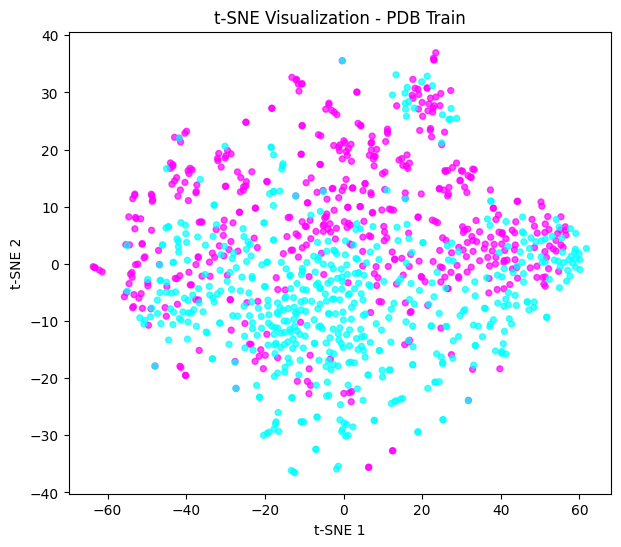

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load data
emb = torch.load("/content/sample_data/x_pdb_train.pt")
# emb shape: (N, D) -- contoh: (800, 128)
labels = np.load("/content/sample_data/y_pdb_train.npy")  # gunakan np.load jika file numpy

# Pastikan ke numpy array
emb_np = emb.numpy() if torch.is_tensor(emb) else emb

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(emb_np)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='cool', s=18, alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization - PDB Train")
plt.show()


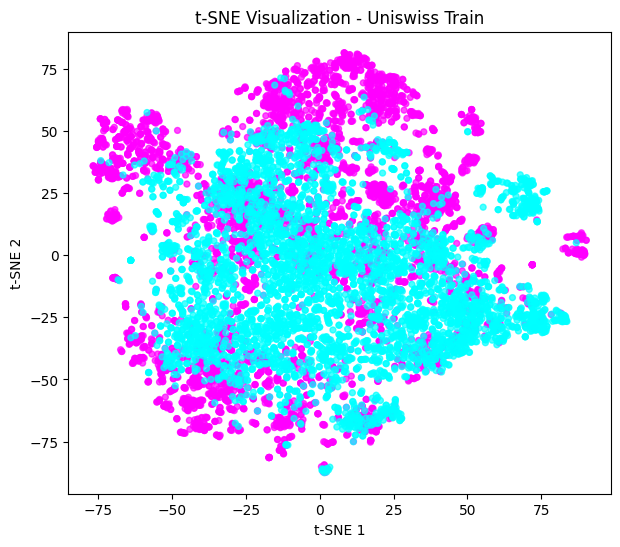

In [ ]:
# Load data
emb = torch.load("/content/sample_data/x_uni_train.pt")
# emb shape: (N, D) -- contoh: (800, 128)
labels = np.load("/content/sample_data/y_uni_train.npy")  # gunakan np.load jika file numpy

# Pastikan ke numpy array
emb_np = emb.numpy() if torch.is_tensor(emb) else emb

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
emb_2d = tsne.fit_transform(emb_np)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='cool', s=18, alpha=0.7)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE Visualization - Uniswiss Train")
plt.show()


# Try Ensemble
try yg settingan train 3

Mulai train supcon...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting SupCon Pretraining (Safe)...

Epoch 1/100 | Train: 3.4332 | Val: 2.5623
Epoch 2/100 | Train: 3.3934 | Val: 2.5726
Epoch 3/100 | Train: 3.3859 | Val: 2.5563
Epoch 4/100 | Train: 3.3742 | Val: 2.5210
Epoch 5/100 | Train: 3.3678 | Val: 2.4778
Epoch 6/100 | Train: 3.3519 | Val: 2.4133
Epoch 7/100 | Train: 3.3417 | Val: 2.3611
Epoch 8/100 | Train: 3.3308 | Val: 2.3070
Epoch 9/100 | Train: 3.3258 | Val: 2.2775
Epoch 10/100 | Train: 3.3171 | Val: 2.2542
Epoch 11/100 | Train: 3.3039 | Val: 2.1930
Epoch 12/100 | Train: 3.2990 | Val: 2.1626
Epoch 13/100 | Train: 3.2846 | Val: 2.1023
Epoch 14/100 | Train: 3.2857 | Val: 2.1569
Epoch 15/100 | Train: 3.2755 | Val: 2.1316
Epoch 16/100 | Train: 3.2696 | Val: 2.1346
Epoch 17/100 | Train: 3.2579 | Val: 1.9829
Epoch 18/100 | Train: 3.2600 | Val: 2.0800
Epoch 19/100 | Train: 3.2457 | Val: 1.9989
Epoch 20/100 | Train: 3.2470 | Val: 1.9734
Epoch 21/100 | Train: 3.2304 | Val: 1.9589
Epoch 22/100 | Train: 3.2331 | Val: 1.9750
Epoch 23/100 | Train:

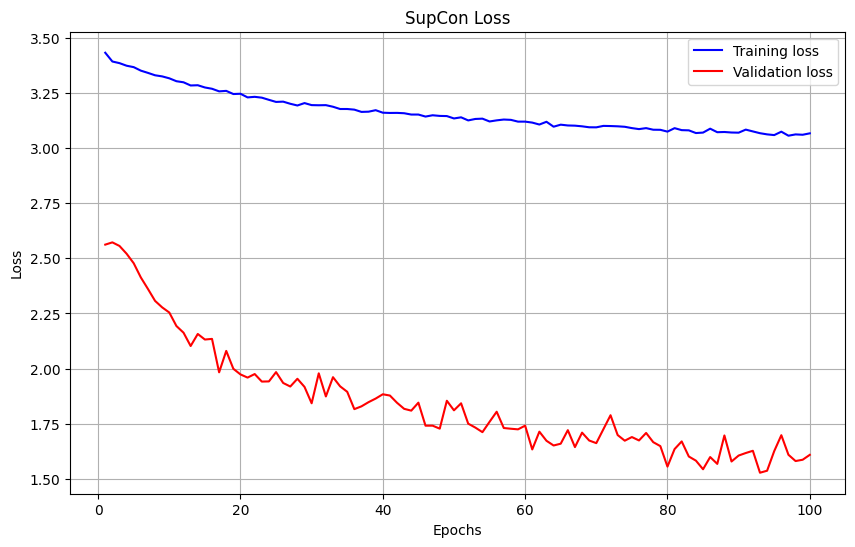

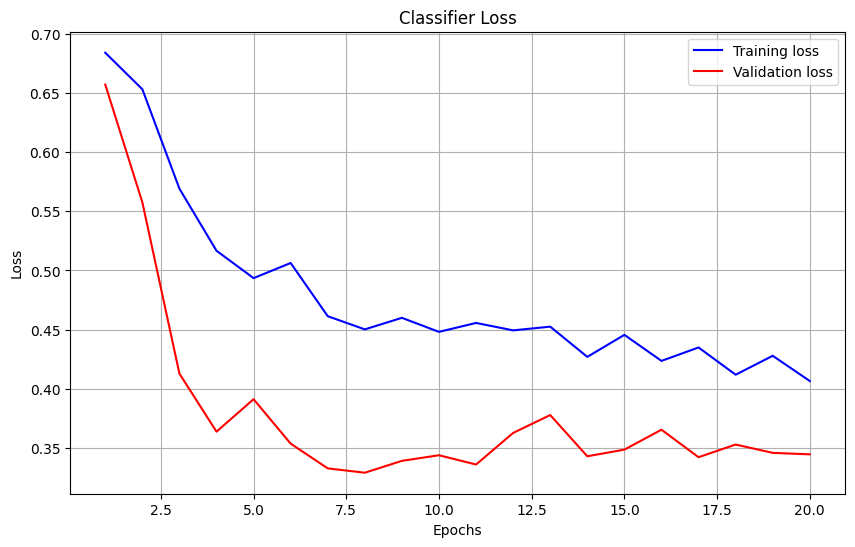


=== Evaluation Result ===
Accuracy:      0.720
Precision(M):  0.739
Recall(M):     0.720
F1 Macro:      0.715
F1 Weighted:   0.715
MCC:           0.459
Specificity:   0.581
ROC-AUC:       0.785

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.806     0.581     0.675        93
    Binding (1)      0.672     0.860     0.755        93

       accuracy                          0.720       186
      macro avg      0.739     0.720     0.715       186
   weighted avg      0.739     0.720     0.715       186



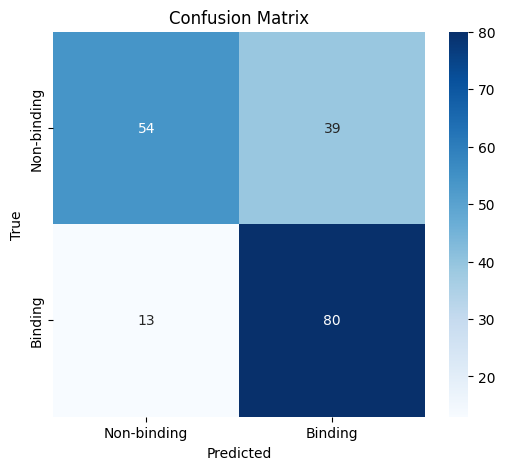

In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=100, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")

print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")

device = torch.device("cpu")

model_pdb_supcon = FullModel(backbone, classifier).to(device)
torch.save(model_pdb_supcon, "trained_pdb_model_supcon.pth")


metrics, preds, probs = evaluate_model(model_pdb_supcon, test_loader_pdb, device=device)




Mulai train supcon...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting SupCon Pretraining (Safe)...

Epoch 1/100 | Train: 3.3490 | Val: 2.5808
Epoch 2/100 | Train: 3.2919 | Val: 2.5473
Epoch 3/100 | Train: 3.2603 | Val: 2.5248
Epoch 4/100 | Train: 3.2333 | Val: 2.5201
Epoch 5/100 | Train: 3.2182 | Val: 2.5030
Epoch 6/100 | Train: 3.2001 | Val: 2.5299
Epoch 7/100 | Train: 3.2014 | Val: 2.4910
Epoch 8/100 | Train: 3.1865 | Val: 2.4840
Epoch 9/100 | Train: 3.1827 | Val: 2.4853
Epoch 10/100 | Train: 3.1743 | Val: 2.4837
Epoch 11/100 | Train: 3.1721 | Val: 2.4761
Epoch 12/100 | Train: 3.1679 | Val: 2.4830
Epoch 13/100 | Train: 3.1647 | Val: 2.4791
Epoch 14/100 | Train: 3.1569 | Val: 2.4855
Epoch 15/100 | Train: 3.1584 | Val: 2.4631
Epoch 16/100 | Train: 3.1466 | Val: 2.4781
Epoch 17/100 | Train: 3.1462 | Val: 2.4791
Epoch 18/100 | Train: 3.1465 | Val: 2.4683
Epoch 19/100 | Train: 3.1406 | Val: 2.4711
Epoch 20/100 | Train: 3.1436 | Val: 2.4536
Epoch 21/100 | Train: 3.1308 | Val: 2.4669
Epoch 22/100 | Train: 3.1340 | Val: 2.4474
Epoch 23/100 | Train:

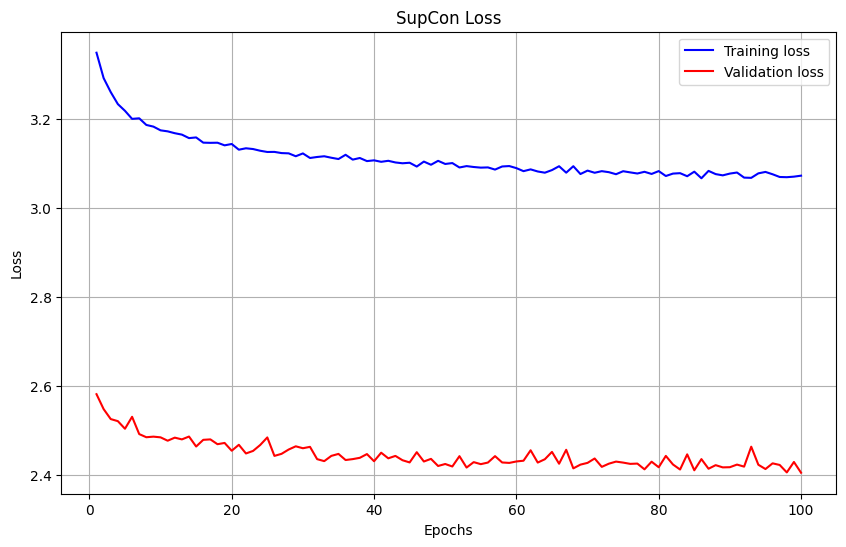

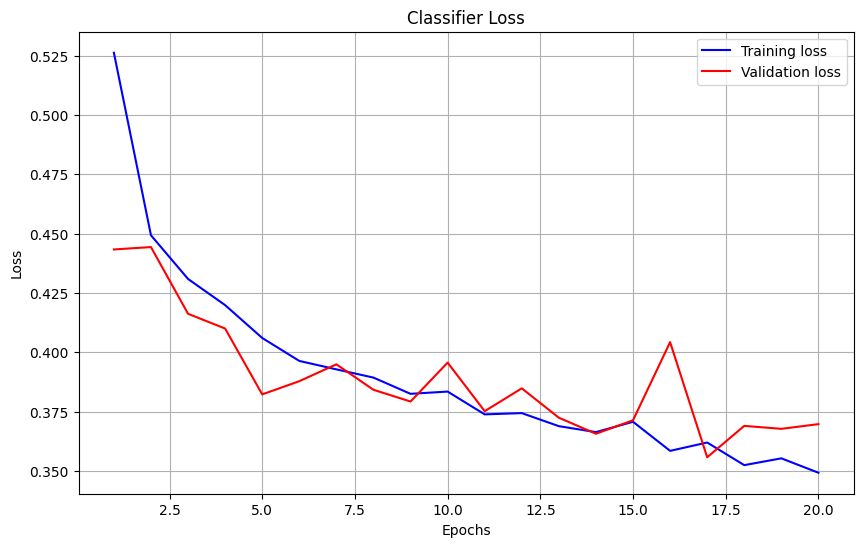


=== Evaluation Result ===
Accuracy:      0.798
Precision(M):  0.805
Recall(M):     0.798
F1 Macro:      0.797
F1 Weighted:   0.797
MCC:           0.603
Specificity:   0.722
ROC-AUC:       0.899

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.851     0.722     0.781       381
    Binding (1)      0.759     0.874     0.812       381

       accuracy                          0.798       762
      macro avg      0.805     0.798     0.797       762
   weighted avg      0.805     0.798     0.797       762



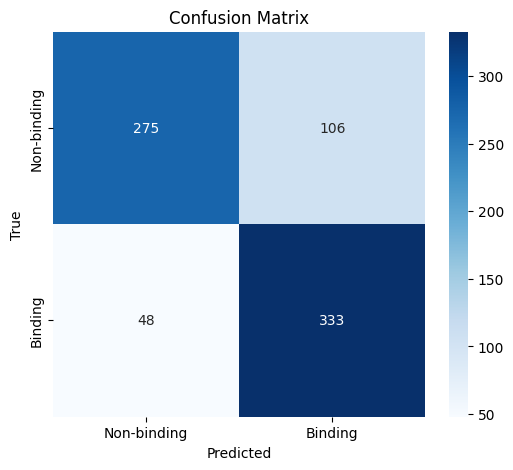

In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_uni, val_loader_uni, epochs=100, lr=1e-4
)

print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_uni, val_loader_uni
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")

device = torch.device("cpu")

model_uni_supcon = FullModel(backbone, classifier).to(device)
torch.save(model_uni_supcon, "trained_uni_model_supcon.pth")


metrics, preds, probs = evaluate_model(model_uni_supcon, test_loader_uni, device=device)




In [ ]:
@torch.no_grad()
def evaluate_ensemble_multi_input(models, weights, dataloaders, device='cpu'):
    """
    Melakukan evaluasi ensemble dengan merata-ratakan LOGITS (sebelum Softmax) dari setiap model
    sesuai dengan bobot yang diberikan. Setiap model menerima Dataloader yang berbeda (Multi-Input).

    Parameters:
    models (list): List model PyTorch yang sudah dimuat (dalam mode .eval()).
    weights (list): List bobot (float) untuk setiap model, misal [0.7, 0.3].
    dataloaders (list): List Dataloader dari data test/validation, harus sama panjang dan berurutan dengan models.
    device (str): Perangkat ('cuda' atau 'cpu').

    Returns:
    tuple: (metrics_dict, y_pred, y_prob)
    """

    # 1. Inisialisasi
    if len(models) != len(dataloaders) or len(models) != len(weights):
        raise ValueError("Jumlah models, weights, dan dataloaders harus sama.")

    for model in models:
        model.eval()

    all_preds = []
    all_labels = []
    all_prob = []
    total_weight = sum(weights)

    print(f"\n--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: {[f'{w/total_weight:.2f}' for w in weights]} ---")

    # 2. Iterator Gabungan
    # Zip dataloaders: Mengambil batch secara paralel (harus sama panjang)
    combined_iterator = zip(*dataloaders)

    for batch_inputs in combined_iterator:

        logits_list = []

        # Ambil label dari Dataloader pertama (asumsi semua dataloader memiliki label yang sama)
        labels = batch_inputs[0][1].to(device)

        # 3. Loop Model dan Data Batch
        for i, (model, w) in enumerate(zip(models, weights)):
            # batch_inputs[i] adalah tuple (X_i, y_i) dari loader ke-i
            X_i = batch_inputs[i][0].to(device)

            # --- Forward Pass dengan Input Khusus ---
            # Jika model Anda membutuhkan unsqueeze (misal untuk CNN/BiLSTM pada sequence),
            # Anda perlu menambahkannya di sini, misalnya:
            # if model_type == 'BiLSTM': X_i = X_i.unsqueeze(1)

            # Logits dari Model Individual
            logits = model(X_i)

            # Bobot diterapkan pada Logits
            logits_list.append(w * logits)

        # 4. Logits Averaging dan Softmax
        combined_logits = torch.stack(logits_list).sum(0) / total_weight
        combined_prob = F.softmax(combined_logits, dim=1)
        preds = torch.argmax(combined_prob, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_prob.extend(combined_prob.cpu().numpy())

    # 5. Perhitungan Metrik
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_prob)

    acc = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob[:, 1])
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    class_report = classification_report(
        y_true, y_pred,
        target_names=["Non-binding (0)", "Binding (1)"],
        digits=3,
        zero_division=0
    )

    # 6. Output & Visualisasi
    print("\n=== Evaluation Result ===")
    print(f"Accuracy:        {acc:.3f}")
    print(f"Precision(M):    {precision_macro:.3f}")
    print(f"Recall(M):       {recall_macro:.3f}")
    print(f"F1 Macro:        {f1_macro:.3f}")
    print(f"F1 Weighted:     {f1_weighted:.3f}")
    print(f"MCC:             {mcc:.3f}")
    print(f"Specificity:     {specificity:.3f}")
    print(f"ROC-AUC:         {roc_auc:.3f}")

    print("\n=== Classification Report ===")
    print(class_report)

    # Visualisasi Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Non-binding", "Binding"],
                yticklabels=["Non-binding", "Binding"])
    plt.title("Confusion Matrix Ensemble Logits Averaging (Multi-Input)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # 7. Return
    metrics_dict = {
        "Accuracy": acc,
        "Precision_macro": precision_macro,
        "Recall_macro": recall_macro,
        "F1_macro": f1_macro,
        "F1_weighted": f1_weighted,
        "MCC": mcc,
        "Specificity": specificity,
        "ROC_AUC": roc_auc,
        "Classification_Report": class_report
    }

    return metrics_dict, y_pred, y_prob

@torch.no_grad()
def esm_embed_sequences(seqs, esm_model, tokenizer):
    """
    Menghasilkan embedding CLS dari sekuens protein menggunakan model ESM.
    Fungsi ini dipanggil di lingkungan CPU.
    """
    device = esm_model.device
    embeddings = []

    # Set model ke eval (jika belum)
    esm_model.eval()

    # Perlu memproses setiap sekuens jika data input adalah list of strings
    for seq in seqs:
        tokens = tokenizer(
            seq,
            return_tensors="pt",
            truncation=True,
            max_length=1024,
            padding='max_length' # Asumsi: jika memproses satu per satu
        )

        # Pindahkan token ke perangkat target (CPU, karena DEVICE='cpu')
        tokens = {k: v.to(device) for k, v in tokens.items()}

        out = esm_model(**tokens)

        # Ambil CLS embedding, pindahkan hasilnya ke CPU, dan hapus dimensi 1
        cls = out.last_hidden_state[:, 0].squeeze().cpu()
        embeddings.append(cls)

    return torch.stack(embeddings) # tensor (N, D) di CPU

In [ ]:
class ComplexMLP_v2(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.3, n_classes=2):
        super(ComplexMLP_v2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.BatchNorm1d(hidden_dim // 8),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim // 8, n_classes)
        )

    def forward(self, x):
        return self.model(x)


# Define the models
def define_model(model_type=None, input_dim=1280, hidden_dim=64, dropout=0.5, n_classes=2, embedding_dim=128, kernel_size=3, n_filters=64, nhead=4):
    if model_type == 'BiLSTM':
        pass # Added pass statement to fix IndentationError
    elif model_type == 'MLP':
        # ARCHITECTURAL CHANGE POINT: Modify number of hidden layers, activation functions, dropout positions
        model = ComplexMLP_v2(input_dim, hidden_dim, dropout, n_classes)

    else:
        raise ValueError("Model type not recognized. Choose from ['BiLSTM', 'CNN', 'Transformer', 'MLP']")

    return model

## Execution
use tes set

### 7:3 (0.838)

--- 1. Loading 1280D Embeddings (Non-SupCon) ---

--- 2. Loading ESM Model for 320D Embeddings ---


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CUDA_VISIBLE_DEVICES diatur ke kosong.
Pengaturan CUDA_VISIBLE_DEVICES dihapus.

--- 3. Loading Trained Models to CPU ---

--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.70', '0.30'] ---

=== Evaluation Result ===
Accuracy:        0.839
Precision(M):    0.844
Recall(M):       0.839
F1 Macro:        0.838
F1 Weighted:     0.838
MCC:             0.683
Specificity:     0.903
ROC-AUC:         0.936

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.800     0.903     0.848        93
    Binding (1)      0.889     0.774     0.828        93

       accuracy                          0.839       186
      macro avg      0.844     0.839     0.838       186
   weighted avg      0.844     0.839     0.838       186



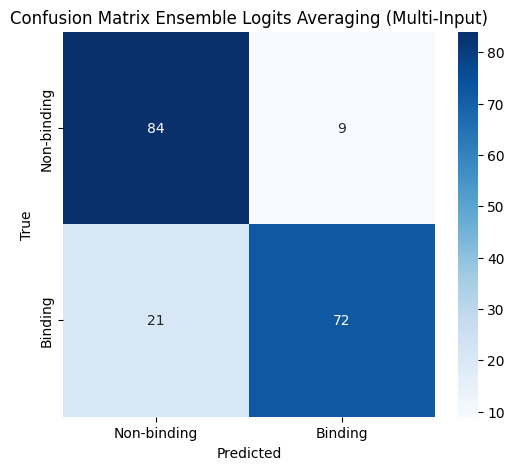

In [ ]:
# Tentukan perangkat tunggal: CPU
DEVICE = torch.device('cpu')
weights = [0.7, 0.3] # % non supcon, % dengan supcon

# --- 2.1 Persiapan Data Loader 1280 (Tanpa SupCon) ---
print("--- 1. Loading 1280D Embeddings (Non-SupCon) ---")
x_pdb_test_emb_1280 = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/x_pdb_test.pt", map_location='cpu').numpy()
y_pdb_test_1280 = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/y_pdb_test.npy")

test_ds_pdb_1280 = TensorDataset(
    torch.tensor(x_pdb_test_emb_1280, dtype=torch.float32),
    torch.tensor(y_pdb_test_1280, dtype=torch.long)
)
test_loader_pdb_1280 = DataLoader(test_ds_pdb_1280, batch_size=32)


# --- 2.2 Persiapan Data Loader 320 (Dengan SupCon) ---
# Tambahkan pemuatan ESM model/tokenizer yang diperlukan oleh fungsi esm_embed_sequences
MODEL_NAME = "facebook/esm2_t6_8M_UR50D" # Asumsi model yang menghasilkan dimensi 320
print("\n--- 2. Loading ESM Model for 320D Embeddings ---")

# Muat model dan tokenizer ke CPU
tokenizer_global = AutoTokenizer.from_pretrained(MODEL_NAME)
esm_model_global = EsmModel.from_pretrained(MODEL_NAME).to(DEVICE)

# Sembunyikan semua GPU secara eksplisit saat membuat embedding (Walaupun sudah CPU, ini menjamin)
os.environ["CUDA_VISIBLE_DEVICES"] = ""
print("CUDA_VISIBLE_DEVICES diatur ke kosong.")

# Panggil fungsi embedding yang dikoreksi
# ASUMSI: df_pdb_test terdefinisi
x_pdb_test_emb_320_tensor = esm_embed_sequences(
    seqs=df_pdb_test['sequence'],
    esm_model=esm_model_global,
    tokenizer=tokenizer_global
)

# Hapus variabel lingkungan
del os.environ["CUDA_VISIBLE_DEVICES"]
print("Pengaturan CUDA_VISIBLE_DEVICES dihapus.")

y_pdb_test_320 = df_pdb_test['label'].values

test_ds_pdb_320 = TensorDataset(
    x_pdb_test_emb_320_tensor,
    torch.tensor(y_pdb_test_320, dtype=torch.long)
)
test_loader_pdb_320 = DataLoader(test_ds_pdb_320, batch_size=32)

# --- 2.3 Muat Model Klasifikasi ---
print("\n--- 3. Loading Trained Models to CPU ---")
model_pdb = torch.load("/content/trained_pdb_model_full.pth", map_location=DEVICE, weights_only=False)
model_pdb_supcon = torch.load("/content/trained_pdb_model_supcon.pth", map_location=DEVICE, weights_only=False)

model_pdb.eval()
model_pdb_supcon.eval()

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

In [ ]:
# Tentukan perangkat tunggal: CPU
DEVICE = torch.device('cpu')
weights = [0.7, 0.3] # % non supcon, % dengan supcon

# --- 2.1 Persiapan Data Loader 1280 (Tanpa SupCon) ---
print("--- 1. Loading 1280D Embeddings (Non-SupCon) ---")
x_uni_test_emb_1280 = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/x_uni_test.pt", map_location='cpu').numpy()
y_uni_test_1280 = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/y_uni_test.npy")

test_ds_uni_1280 = TensorDataset(
    torch.tensor(x_uni_test_emb_1280, dtype=torch.float32),
    torch.tensor(y_uni_test_1280, dtype=torch.long)
)
test_loader_uni_1280 = DataLoader(test_ds_uni_1280, batch_size=32, drop_last=True)

# Panggil fungsi embedding yang dikoreksi
# ASUMSI: df_uni_test terdefinisi
x_uni_test_emb_320_tensor = esm_embed_sequences(
    seqs=df_uni_test['sequence'],
    esm_model=esm_model_global,
    tokenizer=tokenizer_global
)

y_uni_test_320 = df_uni_test['label'].values

test_ds_uni_320 = TensorDataset(
    x_uni_test_emb_320_tensor,
    torch.tensor(y_uni_test_320, dtype=torch.long)
)
test_loader_uni_320 = DataLoader(test_ds_uni_320, batch_size=32, drop_last=True)

# --- 2.3 Muat Model Klasifikasi ---
print("\n--- 3. Loading Trained Models to CPU ---")
model_uni = torch.load("/content/trained_uni_model_full.pth", map_location=DEVICE, weights_only=False)
model_uni_supcon = torch.load("/content/trained_uni_model_supcon.pth", map_location=DEVICE, weights_only=False)

model_uni.eval()
model_uni_supcon.eval()



--- 1. Loading 1280D Embeddings (Non-SupCon) ---

--- 3. Loading Trained Models to CPU ---


FullModel(
  (backbone): ESMBackbone(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 320, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-5): 6 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=320, out_features=320, bias=True)
                (key): Linear(in_features=320, out_features=320, bias=True)
                (value): Linear(in_features=320, out_features=320, bias=True)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=320, out_features=320, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
            )
            (intermediate): EsmI


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.70', '0.30'] ---

=== Evaluation Result ===
Accuracy:        0.923
Precision(M):    0.922
Recall(M):       0.923
F1 Macro:        0.923
F1 Weighted:     0.923
MCC:             0.845
Specificity:     0.925
ROC-AUC:         0.975

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.917     0.925     0.921       358
    Binding (1)      0.928     0.921     0.924       378

       accuracy                          0.923       736
      macro avg      0.922     0.923     0.923       736
   weighted avg      0.923     0.923     0.923       736



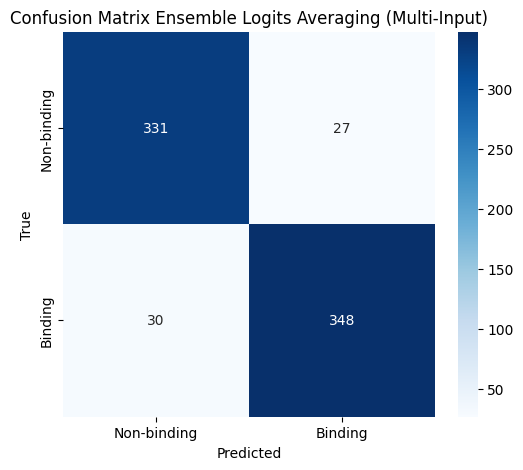

In [ ]:
# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 5:5 (0.828)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.50', '0.50'] ---

=== Evaluation Result ===
Accuracy:        0.828
Precision(M):    0.830
Recall(M):       0.828
F1 Macro:        0.828
F1 Weighted:     0.828
MCC:             0.658
Specificity:     0.871
ROC-AUC:         0.911

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.802     0.871     0.835        93
    Binding (1)      0.859     0.785     0.820        93

       accuracy                          0.828       186
      macro avg      0.830     0.828     0.828       186
   weighted avg      0.830     0.828     0.828       186



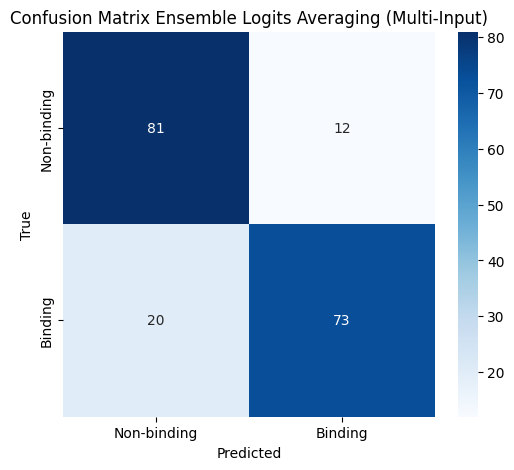

In [ ]:
weights = [0.5, 0.5] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.50', '0.50'] ---

=== Evaluation Result ===
Accuracy:        0.938
Precision(M):    0.937
Recall(M):       0.938
F1 Macro:        0.937
F1 Weighted:     0.938
MCC:             0.875
Specificity:     0.939
ROC-AUC:         0.979

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.933     0.939     0.936       358
    Binding (1)      0.941     0.937     0.939       378

       accuracy                          0.938       736
      macro avg      0.937     0.938     0.937       736
   weighted avg      0.938     0.938     0.938       736



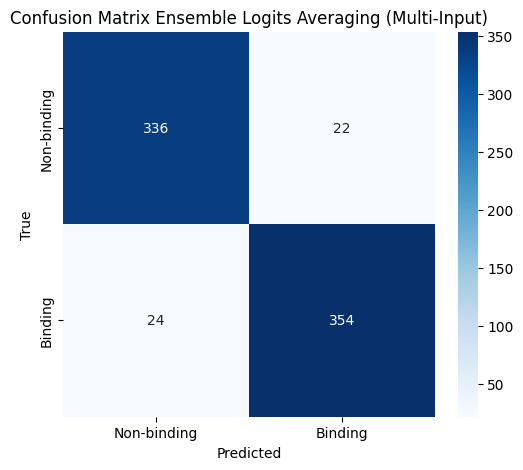

In [ ]:
weights = [0.5, 0.5] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 6:4 (0.833)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.60', '0.40'] ---

=== Evaluation Result ===
Accuracy:        0.833
Precision(M):    0.840
Recall(M):       0.833
F1 Macro:        0.833
F1 Weighted:     0.833
MCC:             0.673
Specificity:     0.903
ROC-AUC:         0.928

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.792     0.903     0.844        93
    Binding (1)      0.887     0.763     0.821        93

       accuracy                          0.833       186
      macro avg      0.840     0.833     0.833       186
   weighted avg      0.840     0.833     0.833       186



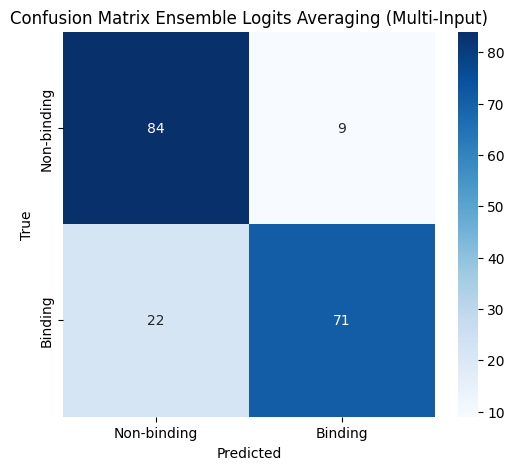

In [ ]:
weights = [0.6, 0.4] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.60', '0.40'] ---

=== Evaluation Result ===
Accuracy:        0.929
Precision(M):    0.929
Recall(M):       0.929
F1 Macro:        0.929
F1 Weighted:     0.929
MCC:             0.859
Specificity:     0.927
ROC-AUC:         0.978

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.927     0.927     0.927       358
    Binding (1)      0.931     0.931     0.931       378

       accuracy                          0.929       736
      macro avg      0.929     0.929     0.929       736
   weighted avg      0.929     0.929     0.929       736



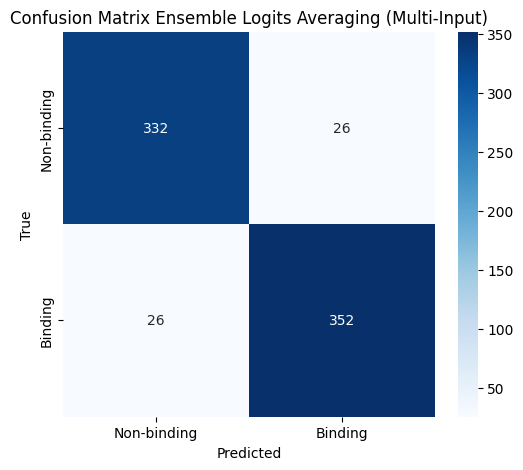

In [ ]:
weights = [0.6, 0.4] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 8:2 (0.859)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.80', '0.20'] ---

=== Evaluation Result ===
Accuracy:        0.860
Precision(M):    0.869
Recall(M):       0.860
F1 Macro:        0.859
F1 Weighted:     0.859
MCC:             0.729
Specificity:     0.935
ROC-AUC:         0.931

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.813     0.935     0.870        93
    Binding (1)      0.924     0.785     0.849        93

       accuracy                          0.860       186
      macro avg      0.869     0.860     0.859       186
   weighted avg      0.869     0.860     0.859       186



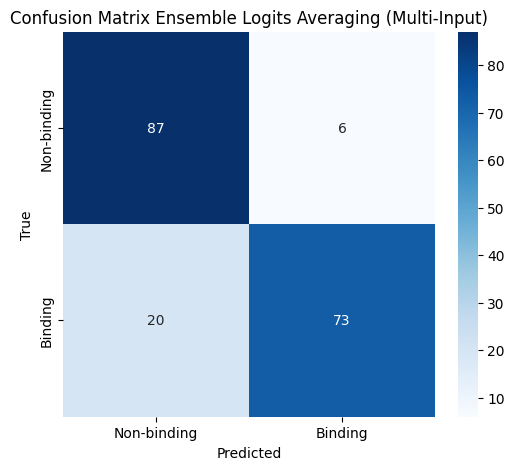

In [ ]:
weights = [0.8, 0.2] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.80', '0.20'] ---

=== Evaluation Result ===
Accuracy:        0.916
Precision(M):    0.916
Recall(M):       0.916
F1 Macro:        0.916
F1 Weighted:     0.916
MCC:             0.831
Specificity:     0.919
ROC-AUC:         0.971

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.909     0.919     0.914       358
    Binding (1)      0.922     0.913     0.918       378

       accuracy                          0.916       736
      macro avg      0.916     0.916     0.916       736
   weighted avg      0.916     0.916     0.916       736



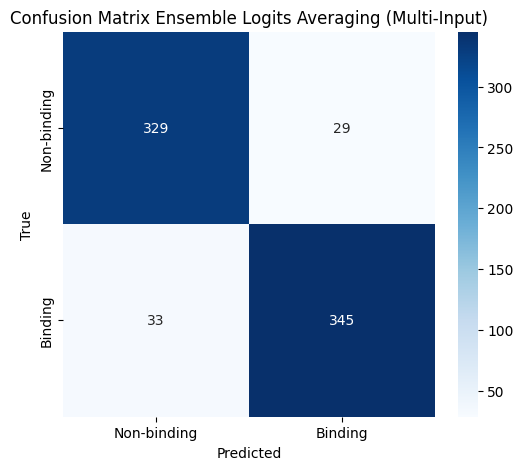

In [ ]:
weights = [0.8, 0.2] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 9:1 (0.821)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.90', '0.10'] ---

=== Evaluation Result ===
Accuracy:        0.823
Precision(M):    0.831
Recall(M):       0.823
F1 Macro:        0.821
F1 Weighted:     0.821
MCC:             0.654
Specificity:     0.903
ROC-AUC:         0.912

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.778     0.903     0.836        93
    Binding (1)      0.885     0.742     0.807        93

       accuracy                          0.823       186
      macro avg      0.831     0.823     0.821       186
   weighted avg      0.831     0.823     0.821       186



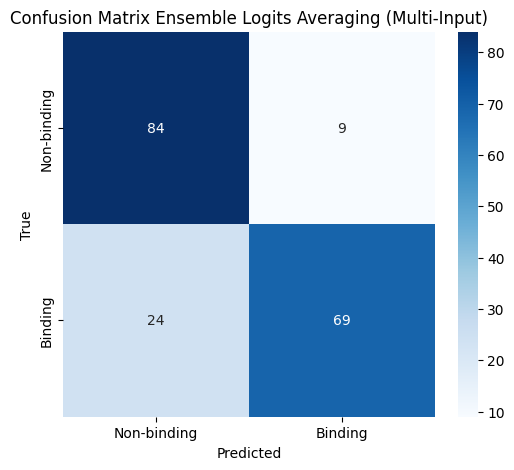

In [ ]:
weights = [0.9, 0.1] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.90', '0.10'] ---

=== Evaluation Result ===
Accuracy:        0.910
Precision(M):    0.910
Recall(M):       0.910
F1 Macro:        0.910
F1 Weighted:     0.910
MCC:             0.821
Specificity:     0.916
ROC-AUC:         0.966

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.901     0.916     0.909       358
    Binding (1)      0.919     0.905     0.912       378

       accuracy                          0.910       736
      macro avg      0.910     0.910     0.910       736
   weighted avg      0.910     0.910     0.910       736



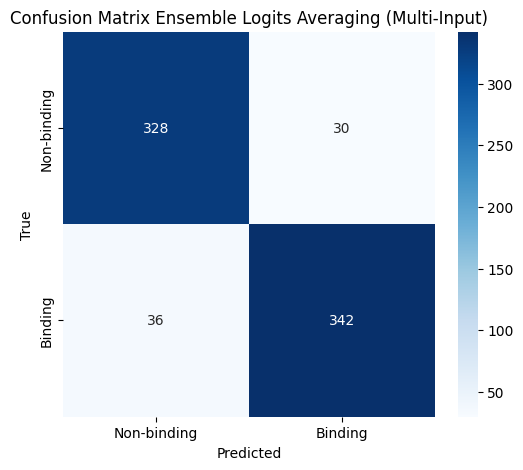

In [ ]:
weights = [0.9, 0.1] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 4:6 (0.806)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.40', '0.60'] ---

=== Evaluation Result ===
Accuracy:        0.806
Precision(M):    0.807
Recall(M):       0.806
F1 Macro:        0.806
F1 Weighted:     0.806
MCC:             0.613
Specificity:     0.817
ROC-AUC:         0.882

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.800     0.817     0.809        93
    Binding (1)      0.813     0.796     0.804        93

       accuracy                          0.806       186
      macro avg      0.807     0.806     0.806       186
   weighted avg      0.807     0.806     0.806       186



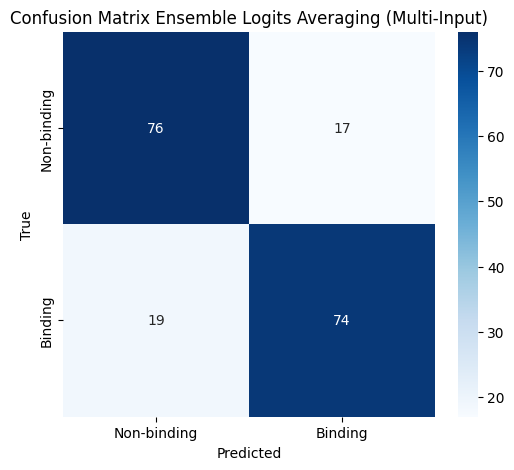

In [ ]:
weights = [0.4, 0.6] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.40', '0.60'] ---

=== Evaluation Result ===
Accuracy:        0.938
Precision(M):    0.937
Recall(M):       0.937
F1 Macro:        0.937
F1 Weighted:     0.938
MCC:             0.875
Specificity:     0.936
ROC-AUC:         0.978

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.936     0.936     0.936       358
    Binding (1)      0.939     0.939     0.939       378

       accuracy                          0.938       736
      macro avg      0.937     0.937     0.937       736
   weighted avg      0.938     0.938     0.938       736



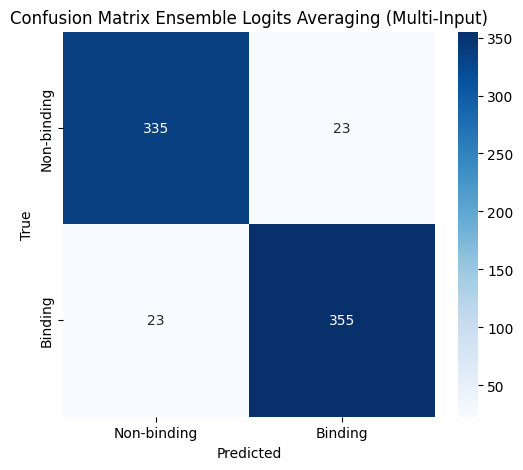

In [ ]:
weights = [0.4, 0.6] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 3:7 (0.785)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.30', '0.70'] ---

=== Evaluation Result ===
Accuracy:        0.785
Precision(M):    0.785
Recall(M):       0.785
F1 Macro:        0.785
F1 Weighted:     0.785
MCC:             0.570
Specificity:     0.785
ROC-AUC:         0.853

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.785     0.785     0.785        93
    Binding (1)      0.785     0.785     0.785        93

       accuracy                          0.785       186
      macro avg      0.785     0.785     0.785       186
   weighted avg      0.785     0.785     0.785       186



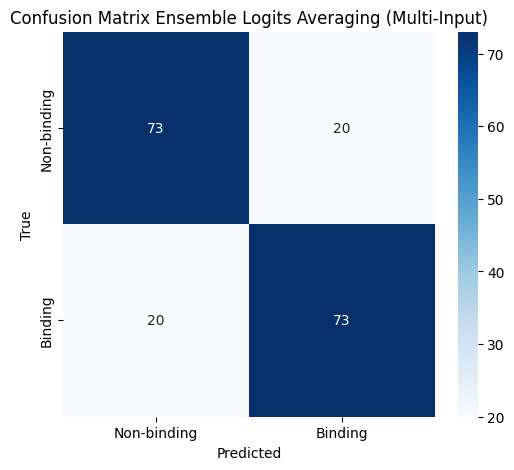

In [ ]:
weights = [0.3, 0.7] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.30', '0.70'] ---

=== Evaluation Result ===
Accuracy:        0.933
Precision(M):    0.933
Recall(M):       0.933
F1 Macro:        0.933
F1 Weighted:     0.933
MCC:             0.867
Specificity:     0.933
ROC-AUC:         0.973

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.930     0.933     0.932       358
    Binding (1)      0.936     0.934     0.935       378

       accuracy                          0.933       736
      macro avg      0.933     0.933     0.933       736
   weighted avg      0.933     0.933     0.933       736



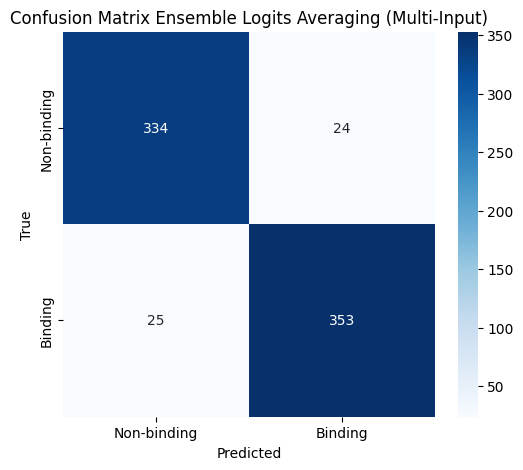

In [ ]:
weights = [0.3, 0.7] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 2:8 (0.747)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.20', '0.80'] ---

=== Evaluation Result ===
Accuracy:        0.747
Precision(M):    0.747
Recall(M):       0.747
F1 Macro:        0.747
F1 Weighted:     0.747
MCC:             0.495
Specificity:     0.742
ROC-AUC:         0.824

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.750     0.742     0.746        93
    Binding (1)      0.745     0.753     0.749        93

       accuracy                          0.747       186
      macro avg      0.747     0.747     0.747       186
   weighted avg      0.747     0.747     0.747       186



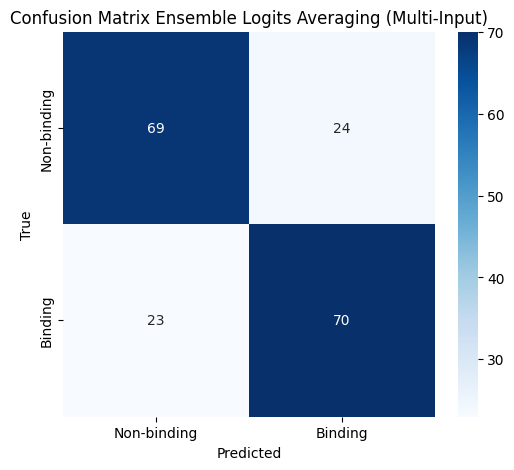

In [ ]:
weights = [0.2, 0.8] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.20', '0.80'] ---

=== Evaluation Result ===
Accuracy:        0.923
Precision(M):    0.923
Recall(M):       0.922
F1 Macro:        0.922
F1 Weighted:     0.923
MCC:             0.845
Specificity:     0.913
ROC-AUC:         0.962

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.926     0.913     0.920       358
    Binding (1)      0.919     0.931     0.925       378

       accuracy                          0.923       736
      macro avg      0.923     0.922     0.922       736
   weighted avg      0.923     0.923     0.923       736



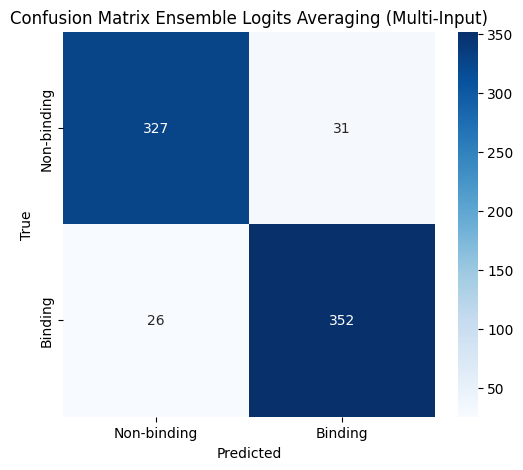

In [ ]:
weights = [0.2, 0.8] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

### 1:9 (0.737)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.10', '0.90'] ---

=== Evaluation Result ===
Accuracy:        0.737
Precision(M):    0.737
Recall(M):       0.737
F1 Macro:        0.737
F1 Weighted:     0.737
MCC:             0.473
Specificity:     0.731
ROC-AUC:         0.797

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.739     0.731     0.735        93
    Binding (1)      0.734     0.742     0.738        93

       accuracy                          0.737       186
      macro avg      0.737     0.737     0.737       186
   weighted avg      0.737     0.737     0.737       186



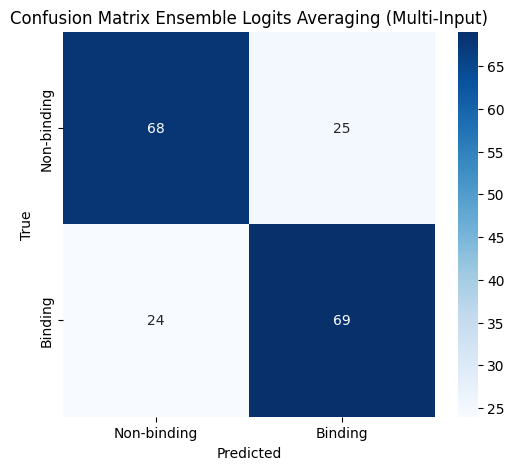

In [ ]:
weights = [0.1, 0.9] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.10', '0.90'] ---

=== Evaluation Result ===
Accuracy:        0.875
Precision(M):    0.875
Recall(M):       0.875
F1 Macro:        0.875
F1 Weighted:     0.875
MCC:             0.750
Specificity:     0.866
ROC-AUC:         0.940

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.876     0.866     0.871       358
    Binding (1)      0.874     0.884     0.879       378

       accuracy                          0.875       736
      macro avg      0.875     0.875     0.875       736
   weighted avg      0.875     0.875     0.875       736



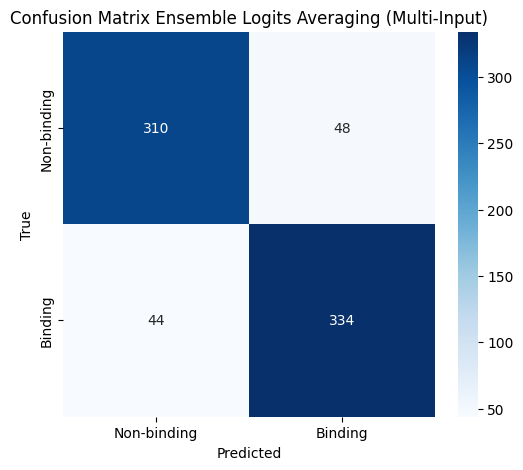

In [ ]:
weights = [0.1, 0.9] # % non supcon, % dengan supcon

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

# Try cross

Mulai train supcon...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting SupCon Pretraining (Safe)...

Epoch 1/100 | Train: 3.4332 | Val: 2.5623
Epoch 2/100 | Train: 3.3934 | Val: 2.5726
Epoch 3/100 | Train: 3.3859 | Val: 2.5563
Epoch 4/100 | Train: 3.3742 | Val: 2.5210
Epoch 5/100 | Train: 3.3678 | Val: 2.4778
Epoch 6/100 | Train: 3.3519 | Val: 2.4133
Epoch 7/100 | Train: 3.3417 | Val: 2.3611
Epoch 8/100 | Train: 3.3308 | Val: 2.3070
Epoch 9/100 | Train: 3.3258 | Val: 2.2775
Epoch 10/100 | Train: 3.3171 | Val: 2.2542
Epoch 11/100 | Train: 3.3039 | Val: 2.1930
Epoch 12/100 | Train: 3.2990 | Val: 2.1626
Epoch 13/100 | Train: 3.2846 | Val: 2.1023
Epoch 14/100 | Train: 3.2857 | Val: 2.1569
Epoch 15/100 | Train: 3.2755 | Val: 2.1316
Epoch 16/100 | Train: 3.2696 | Val: 2.1346
Epoch 17/100 | Train: 3.2579 | Val: 1.9829
Epoch 18/100 | Train: 3.2600 | Val: 2.0800
Epoch 19/100 | Train: 3.2457 | Val: 1.9989
Epoch 20/100 | Train: 3.2470 | Val: 1.9734
Epoch 21/100 | Train: 3.2304 | Val: 1.9589
Epoch 22/100 | Train: 3.2331 | Val: 1.9750
Epoch 23/100 | Train:

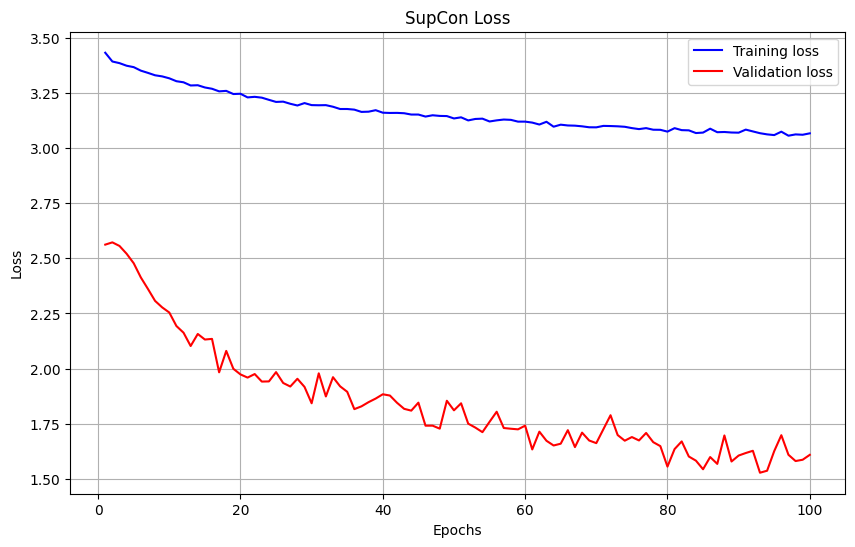

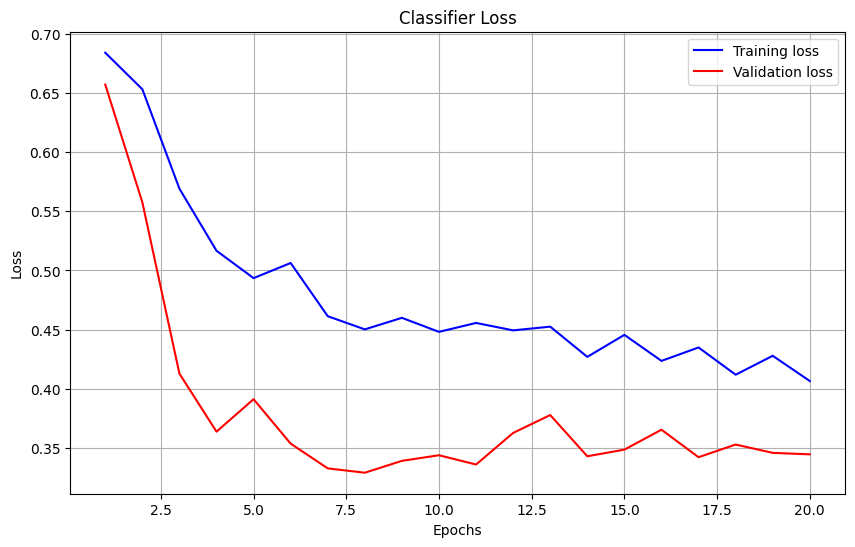


=== Evaluation Result ===
Accuracy:      0.720
Precision(M):  0.739
Recall(M):     0.720
F1 Macro:      0.715
F1 Weighted:   0.715
MCC:           0.459
Specificity:   0.581
ROC-AUC:       0.785

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.806     0.581     0.675        93
    Binding (1)      0.672     0.860     0.755        93

       accuracy                          0.720       186
      macro avg      0.739     0.720     0.715       186
   weighted avg      0.739     0.720     0.715       186



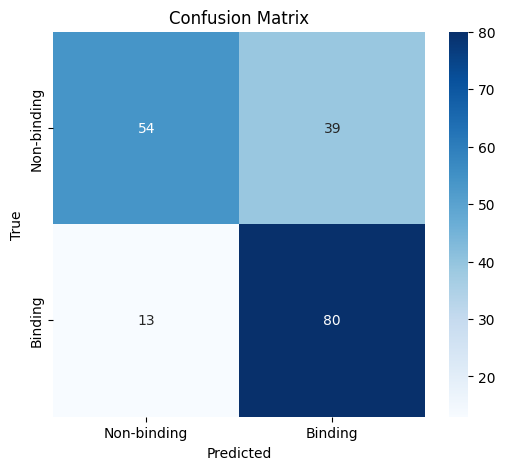

In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_pdb, val_loader_pdb, epochs=100, lr=1e-4
)

torch.save(backbone.state_dict(), "supcon_esm_backbone.pt")
print("Backbone SupCon saved ✔")

print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_pdb, val_loader_pdb
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")

device = torch.device("cpu")

model_pdb_supcon = FullModel(backbone, classifier).to(device)
torch.save(model_pdb_supcon, "trained_pdb_model_supcon.pth")


metrics, preds, probs = evaluate_model(model_pdb_supcon, test_loader_pdb, device=device)




Mulai train supcon...


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 Starting SupCon Pretraining (Safe)...

Epoch 1/100 | Train: 3.3490 | Val: 2.5808
Epoch 2/100 | Train: 3.2919 | Val: 2.5473
Epoch 3/100 | Train: 3.2603 | Val: 2.5248
Epoch 4/100 | Train: 3.2333 | Val: 2.5201
Epoch 5/100 | Train: 3.2182 | Val: 2.5030
Epoch 6/100 | Train: 3.2001 | Val: 2.5299
Epoch 7/100 | Train: 3.2014 | Val: 2.4910
Epoch 8/100 | Train: 3.1865 | Val: 2.4840
Epoch 9/100 | Train: 3.1827 | Val: 2.4853
Epoch 10/100 | Train: 3.1743 | Val: 2.4837
Epoch 11/100 | Train: 3.1721 | Val: 2.4761
Epoch 12/100 | Train: 3.1679 | Val: 2.4830
Epoch 13/100 | Train: 3.1647 | Val: 2.4791
Epoch 14/100 | Train: 3.1569 | Val: 2.4855
Epoch 15/100 | Train: 3.1584 | Val: 2.4631
Epoch 16/100 | Train: 3.1466 | Val: 2.4781
Epoch 17/100 | Train: 3.1462 | Val: 2.4791
Epoch 18/100 | Train: 3.1465 | Val: 2.4683
Epoch 19/100 | Train: 3.1406 | Val: 2.4711
Epoch 20/100 | Train: 3.1436 | Val: 2.4536
Epoch 21/100 | Train: 3.1308 | Val: 2.4669
Epoch 22/100 | Train: 3.1340 | Val: 2.4474
Epoch 23/100 | Train:

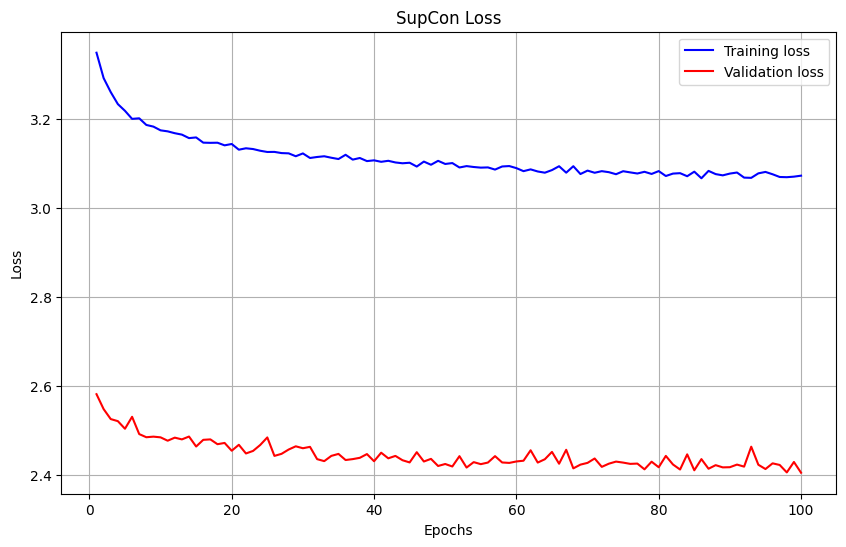

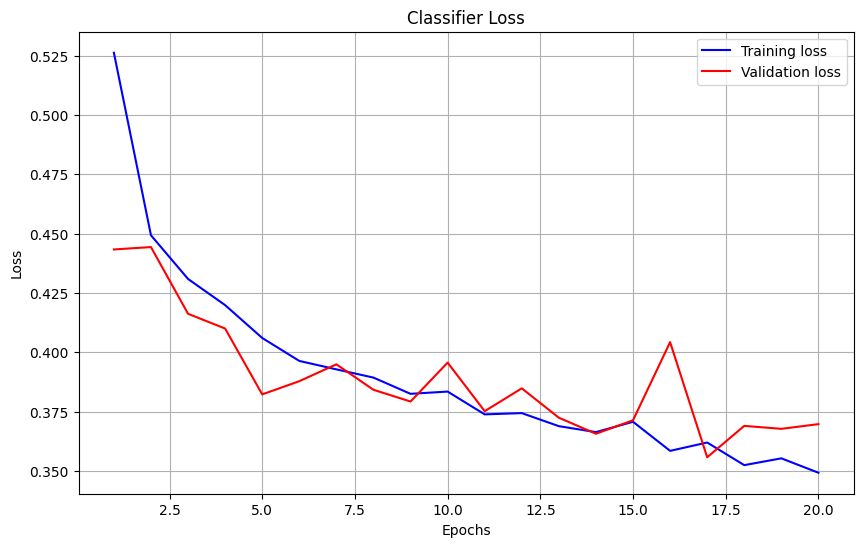


=== Evaluation Result ===
Accuracy:      0.798
Precision(M):  0.805
Recall(M):     0.798
F1 Macro:      0.797
F1 Weighted:   0.797
MCC:           0.603
Specificity:   0.722
ROC-AUC:       0.899

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.851     0.722     0.781       381
    Binding (1)      0.759     0.874     0.812       381

       accuracy                          0.798       762
      macro avg      0.805     0.798     0.797       762
   weighted avg      0.805     0.798     0.797       762



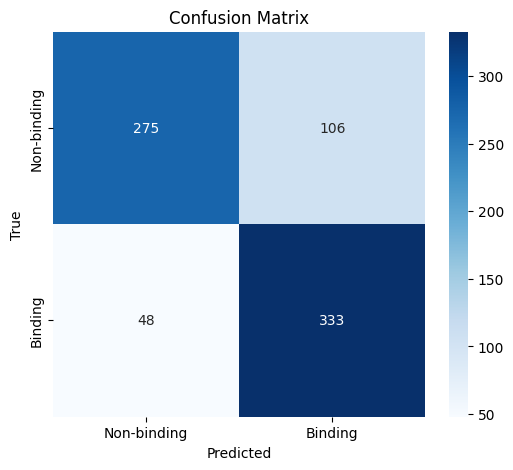

In [ ]:
print("Mulai train supcon...")
backbone = ESMBackbone()
backbone, supcon_train, supcon_val = train_supcon(
    backbone, train_loader_uni, val_loader_uni, epochs=100, lr=1e-4
)

print("Mulai train classifier...")
classifier = MLPClassifier(input_dim=backbone.hidden_dim)

classifier, clf_train, clf_val, clf_acc = train_classifier(
    backbone, classifier, train_loader_uni, val_loader_uni
)

plot_losses(supcon_train, supcon_val, "SupCon Loss")
plot_losses(clf_train, clf_val, "Classifier Loss")

device = torch.device("cpu")

model_uni_supcon = FullModel(backbone, classifier).to(device)
torch.save(model_uni_supcon, "trained_uni_model_supcon.pth")


metrics, preds, probs = evaluate_model(model_uni_supcon, test_loader_uni, device=device)




--- 1. Loading 1280D Embeddings (Non-SupCon) ---

--- 2. Loading ESM Model for 320D Embeddings ---


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CUDA_VISIBLE_DEVICES diatur ke kosong.
Pengaturan CUDA_VISIBLE_DEVICES dihapus.

--- 3. Loading Trained Models to CPU ---

--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.60', '0.40'] ---

=== Evaluation Result ===
Accuracy:        0.882
Precision(M):    0.886
Recall(M):       0.882
F1 Macro:        0.881
F1 Weighted:     0.881
MCC:             0.768
Specificity:     0.828
ROC-AUC:         0.948

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.928     0.828     0.875        93
    Binding (1)      0.845     0.935     0.888        93

       accuracy                          0.882       186
      macro avg      0.886     0.882     0.881       186
   weighted avg      0.886     0.882     0.881       186



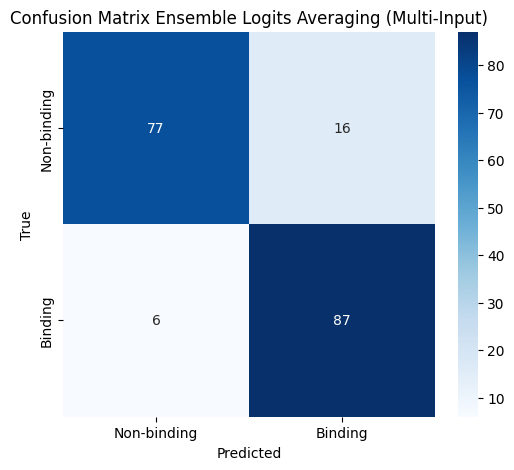

In [ ]:
# Tentukan perangkat tunggal: CPU
DEVICE = torch.device('cpu')
weights = [0.6, 0.4] # % non supcon, % dengan supcon

# --- 2.1 Persiapan Data Loader 1280 (Tanpa SupCon) ---
print("--- 1. Loading 1280D Embeddings (Non-SupCon) ---")
x_pdb_test_emb_1280 = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/x_pdb_test.pt", map_location='cpu').numpy()
y_pdb_test_1280 = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/PDB/y_pdb_test.npy")

test_ds_pdb_1280 = TensorDataset(
    torch.tensor(x_pdb_test_emb_1280, dtype=torch.float32),
    torch.tensor(y_pdb_test_1280, dtype=torch.long)
)
test_loader_pdb_1280 = DataLoader(test_ds_pdb_1280, batch_size=32)


# --- 2.2 Persiapan Data Loader 320 (Dengan SupCon) ---
# Tambahkan pemuatan ESM model/tokenizer yang diperlukan oleh fungsi esm_embed_sequences
MODEL_NAME = "facebook/esm2_t6_8M_UR50D" # Asumsi model yang menghasilkan dimensi 320
print("\n--- 2. Loading ESM Model for 320D Embeddings ---")

# Muat model dan tokenizer ke CPU
tokenizer_global = AutoTokenizer.from_pretrained(MODEL_NAME)
esm_model_global = EsmModel.from_pretrained(MODEL_NAME).to(DEVICE)

# Sembunyikan semua GPU secara eksplisit saat membuat embedding (Walaupun sudah CPU, ini menjamin)
os.environ["CUDA_VISIBLE_DEVICES"] = ""
print("CUDA_VISIBLE_DEVICES diatur ke kosong.")

# Panggil fungsi embedding yang dikoreksi
# ASUMSI: df_pdb_test terdefinisi
x_pdb_test_emb_320_tensor = esm_embed_sequences(
    seqs=df_pdb_test['sequence'],
    esm_model=esm_model_global,
    tokenizer=tokenizer_global
)

# Hapus variabel lingkungan
del os.environ["CUDA_VISIBLE_DEVICES"]
print("Pengaturan CUDA_VISIBLE_DEVICES dihapus.")

y_pdb_test_320 = df_pdb_test['label'].values

test_ds_pdb_320 = TensorDataset(
    x_pdb_test_emb_320_tensor,
    torch.tensor(y_pdb_test_320, dtype=torch.long)
)
test_loader_pdb_320 = DataLoader(test_ds_pdb_320, batch_size=32)

# --- 2.3 Muat Model Klasifikasi ---
print("\n--- 3. Loading Trained Models to CPU ---")
model_pdb = torch.load("/content/trained_pdb_model_full.pth", map_location=DEVICE, weights_only=False)
model_pdb_supcon = torch.load("/content/trained_pdb_model_supcon.pth", map_location=DEVICE, weights_only=False)

model_pdb.eval()
model_pdb_supcon.eval()

# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)

In [ ]:
# Tentukan perangkat tunggal: CPU
DEVICE = torch.device('cpu')
weights = [0.6, 0.4] # % non supcon, % dengan supcon

# --- 2.1 Persiapan Data Loader 1280 (Tanpa SupCon) ---
print("--- 1. Loading 1280D Embeddings (Non-SupCon) ---")
x_uni_test_emb_1280 = torch.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/x_uni_test.pt", map_location='cpu').numpy()
y_uni_test_1280 = np.load("/content/drive/MyDrive/Bioinformatika/esm_embed_2/UNI/y_uni_test.npy")

test_ds_uni_1280 = TensorDataset(
    torch.tensor(x_uni_test_emb_1280, dtype=torch.float32),
    torch.tensor(y_uni_test_1280, dtype=torch.long)
)
test_loader_uni_1280 = DataLoader(test_ds_uni_1280, batch_size=32, drop_last=True)

# Panggil fungsi embedding yang dikoreksi
# ASUMSI: df_uni_test terdefinisi
x_uni_test_emb_320_tensor = esm_embed_sequences(
    seqs=df_uni_test['sequence'],
    esm_model=esm_model_global,
    tokenizer=tokenizer_global
)

y_uni_test_320 = df_uni_test['label'].values

test_ds_uni_320 = TensorDataset(
    x_uni_test_emb_320_tensor,
    torch.tensor(y_uni_test_320, dtype=torch.long)
)
test_loader_uni_320 = DataLoader(test_ds_uni_320, batch_size=32, drop_last=True)

# --- 2.3 Muat Model Klasifikasi ---
print("\n--- 3. Loading Trained Models to CPU ---")
model_uni = torch.load("/content/trained_uni_model_full.pth", map_location=DEVICE, weights_only=False)
model_uni_supcon = torch.load("/content/trained_uni_model_supcon.pth", map_location=DEVICE, weights_only=False)

model_uni.eval()
model_uni_supcon.eval()



--- 1. Loading 1280D Embeddings (Non-SupCon) ---

--- 3. Loading Trained Models to CPU ---


FullModel(
  (backbone): ESMBackbone(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 320, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-5): 6 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=320, out_features=320, bias=True)
                (key): Linear(in_features=320, out_features=320, bias=True)
                (value): Linear(in_features=320, out_features=320, bias=True)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=320, out_features=320, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
            )
            (intermediate): EsmI


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.60', '0.40'] ---

=== Evaluation Result ===
Accuracy:        0.921
Precision(M):    0.921
Recall(M):       0.922
F1 Macro:        0.921
F1 Weighted:     0.921
MCC:             0.843
Specificity:     0.933
ROC-AUC:         0.976

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.908     0.933     0.920       358
    Binding (1)      0.935     0.910     0.922       378

       accuracy                          0.921       736
      macro avg      0.921     0.922     0.921       736
   weighted avg      0.922     0.921     0.921       736



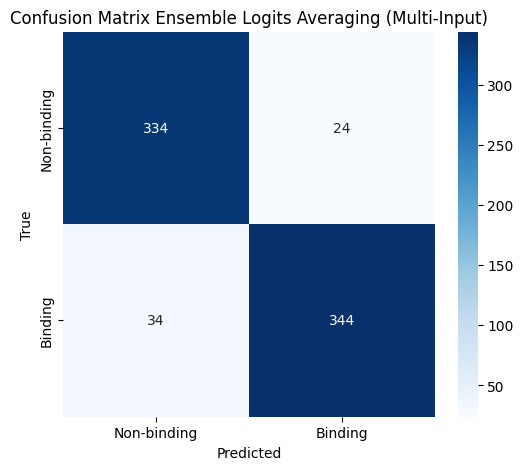

In [ ]:
# --- 2.4 Eksekusi Ensemble ---
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)

crossss



--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.60', '0.40'] ---

=== Evaluation Result ===
Accuracy:        0.795
Precision(M):    0.821
Recall(M):       0.791
F1 Macro:        0.789
F1 Weighted:     0.790
MCC:             0.611
Specificity:     0.645
ROC-AUC:         0.879

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.906     0.645     0.754       358
    Binding (1)      0.736     0.937     0.824       378

       accuracy                          0.795       736
      macro avg      0.821     0.791     0.789       736
   weighted avg      0.819     0.795     0.790       736



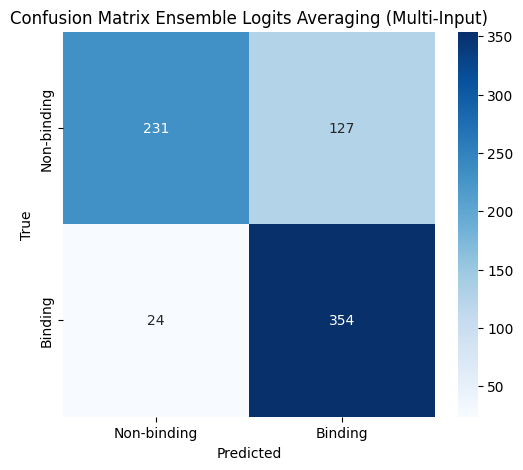

In [ ]:
# cross model pdb
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_pdb, model_pdb_supcon],
    weights=weights,
    dataloaders=[test_loader_uni_1280, test_loader_uni_320],
    device=DEVICE
)


--- 4. Starting Ensemble Evaluation ---

--- Memulai Ensemble Evaluation (Multi-Input) dengan Bobot: ['0.60', '0.40'] ---

=== Evaluation Result ===
Accuracy:        0.790
Precision(M):    0.798
Recall(M):       0.790
F1 Macro:        0.789
F1 Weighted:     0.789
MCC:             0.588
Specificity:     0.871
ROC-AUC:         0.905

=== Classification Report ===
                 precision    recall  f1-score   support

Non-binding (0)      0.750     0.871     0.806        93
    Binding (1)      0.846     0.710     0.772        93

       accuracy                          0.790       186
      macro avg      0.798     0.790     0.789       186
   weighted avg      0.798     0.790     0.789       186



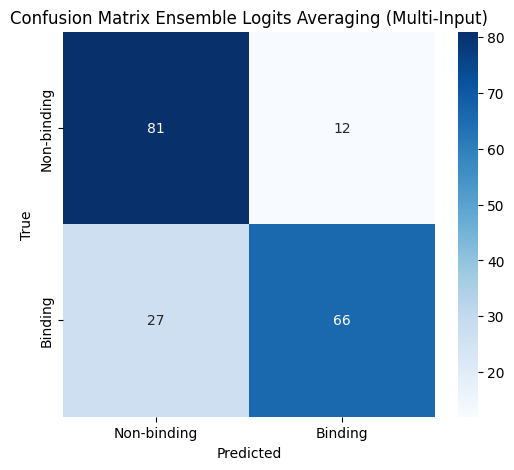

In [ ]:
# --- cross model uni
print("\n--- 4. Starting Ensemble Evaluation ---")
metrics, preds, probs = evaluate_ensemble_multi_input(
    models=[model_uni, model_uni_supcon],
    weights=weights,
    dataloaders=[test_loader_pdb_1280, test_loader_pdb_320],
    device=DEVICE
)